## Imports

In [136]:
import sys
import time
import importlib
import sparse
import datetime
import pandas as pd
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt

import Utils.dbutils as dbutils
import Utils.data_utils as data_utils
# import Utils.PopulateAux as PopulateAux
import Generators.CohortGenerator as CohortGenerator
import Generators.FeatureGenerator as FeatureGenerator
import config
local_imports = (
    dbutils,
    data_utils,
    # PopulateAux,
    CohortGenerator,
    FeatureGenerator,
    config
)
for i in local_imports:
    i = importlib.reload(i)

## Cohort, Outcome and Feature Collection

### 1. Set up a connection to the OMOP CDM database

Parameters for connection to be specified in ./config.py

In [138]:
# database connection
username = config.PG_USERNAME
password = config.PG_PASSWORD
database_name = config.DB_NAME

config_path = 'postgresql://{username}:{password}@{database_name}'.format(
    username = username,
    password = password,
    database_name = database_name
)

# schemas 
schema_name = 'flexible_windows_test' # all created tables will be created using this schema

# caching
reset_schema = False # if true, rebuild all data from scratch

# set up database, reset schemas as needed
db = dbutils.Database(config_path, schema_name)
if reset_schema:
    db.execute(
        'drop schema if exists {} cascade'.format(schema_name)
    )
db.execute(
    'create schema if not exists {}'.format(schema_name)
)

/home/justinl/miniconda3/lib/python3.7/site-packages/sqlalchemy/dialects/postgresql/base.py:3323: SAWarning: Skipped unsupported reflection of expression-based index idx__loc_source_value
  "expression-based index %s" % idx_name


Executed 1 SQLs


### Build a Cohort for the End of Life Prediction Task

##### Create a Cohort Object that can be constructed as specified by SQL File & Params

In [141]:
cohort_name = 'test_cohort_small'
cohort_script_path = config.SQL_PATH_COHORTS + '/test_cohort_small.sql'

# cohort parameters  
params = {
          'cohort_table_name'     : cohort_name,
          'schema_name'           : schema_name,
          'gap'                   : '3 months',
          'outcome_window'        : '6 months',
          'eligibility_period'    : '1 year',       ## Enrollment duration before prediction time
          'positive_pred_unif'    : 'false',        ## If 'true', then uniformly sample deltas...
          'positive_pred_delta'   : '6 months',     ## ...otherwise, fixed interval.
          'negative_pred_date'    : '2017-01-01',   ## Constant for now, experiments TBD
          'dummy_date'            : '2100-01-01'    ## Can be arbitrary, but must be consistent with feature SQL scripts
         }

cohort = CohortGenerator.Cohort(
    schema_name=schema_name,
    cohort_table_name=cohort_name,
    cohort_generation_script=cohort_script_path,
    cohort_generation_kwargs=params,
    outcome_col_name='y'
)

##### Build Cohort

In [142]:
cohort.build(db, replace=True)

Regenerating Table (replace=True)
Regenerated Cohort in 17.768906593322754 seconds


### Get a Time Series of Features for Cohort Members

In [143]:
featureSet = FeatureGenerator.FeatureSet(db)
featureSet.add_default_features(
    ['drugs_relative','conditions_relative','procedures_relative','specialty_relative'],
    schema_name,
    cohort_name
)

In [144]:
%%time
# Build the Feature Set by executing SQL queries and reading into sparse matrices
cache_data_path = '/tmp/cache_data_flexible_test_small'
featureSet.build(cohort, from_cached=False, cache_file=cache_data_path)

Data loaded to buffer in 301.57 seconds
Got Unique Concepts and Timestamps in 4.72 seconds
Created Index Mappings in 0.01 seconds
7089
Generated Sparse Representation of Data in 12.49 seconds
CPU times: user 20.4 s, sys: 2.28 s, total: 22.6 s
Wall time: 5min 18s


In [145]:
outcomes_filt, feature_matrix_3d_transpose, remap, good_feature_names = \
    FeatureGenerator.postprocess_feature_matrix(cohort, featureSet, training_end_date_col='dummy_date')

### Build a Model to Predict End of Life using this data

#### Transform Data to get a vector of counts over 1, 6, 12, 24 and infinity (represented by 10000 days) month windows for each Patient

In [146]:
%%time
feature_matrix_counts, feature_names = data_utils.window_data(
    window_lengths = [30, 180, 365, 730, 10000],
    feature_matrix = feature_matrix_3d_transpose,
    all_feature_names = good_feature_names,
    cohort = cohort,
    featureSet = featureSet,
    cohort_end_date_col = 'dummy_date'
)

CPU times: user 24.9 s, sys: 160 ms, total: 25 s
Wall time: 25 s


In [178]:
feature_matrix_counts.T

<6784x90025 sparse matrix of type '<class 'numpy.float64'>'
	with 1426367 stored elements in Compressed Sparse Column format>

In [184]:
outcomes_filt.value_counts()

0    5154
1    1630
Name: y, dtype: int64

#### Set up a standard sklearn modelling pipeline

In [148]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

lr = LogisticRegression(
    class_weight='balanced', C=0.02,
    penalty='l1', fit_intercept=True,
    solver='liblinear', random_state=0,
    verbose=0, max_iter = 200, tol=1e-1
)

def sparse_ufunc(f):
    def wrapper(*a, **k):
        X = a[0]
        if not scipy.sparse.isspmatrix(X):
            raise ValueError
        X2 = X.copy()
        X2.data = f(X2.data, *(a[1:]), **k)
        return X2
    return wrapper

@sparse_ufunc
def tr_func(X, kwarg=1):
    return np.clip(X, 0, kwarg)

func = FunctionTransformer(
    func=tr_func,
    accept_sparse=True,
    validate=True,
    kw_args={'kwarg': 1}
)

# The classifier will transform each data point using func, which here takes a count vector to a binary vector
# Then, it will use logistic regression to classify the transformed data
clf = Pipeline([
    ('func',func),
    ('lr', lr)
])

#### Instantiate, Train and Test Model

In [149]:
indices = range(len(outcomes_filt))
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    feature_matrix_counts.T, outcomes_filt, indices,
    test_size=0.2, random_state=1
)
clf.fit(X_train, y_train)
pred = clf.predict_proba(X_test)[:, 1]
print('Model Test AUC: {0:.2f}'.format(roc_auc_score(y_test, pred)))

Model Test AUC: 0.86


#### Evaluate Model : RoC and Precision-Recall Curves

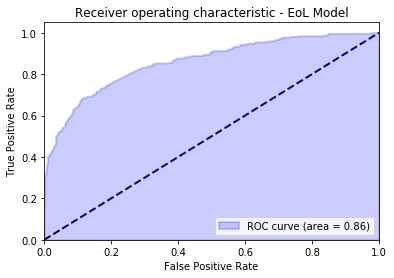

In [150]:
fpr, tpr, _ = roc_curve(y_test, pred)
plt.figure()
lw = 2
plt.fill_between(fpr, tpr, color='b', alpha = 0.2,
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, pred))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - EoL Model')
plt.legend(loc="lower right")
plt.show()

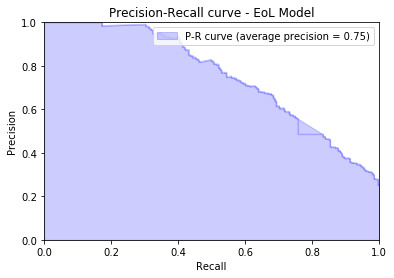

In [155]:
precision, recall, _ = precision_recall_curve(y_test, pred)

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, pred)

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(
    recall, precision, alpha=0.2, color='b',
    label='P-R curve (average precision = %0.2f)' % average_precision
)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Precision-Recall curve - EoL Model')
plt.show()

#### Evaluate Model : Extract Feature Weights

In [152]:
feature_weights = pd.DataFrame({
    'feature_name': feature_names,
    'feature_weight': list(clf.get_params()['lr'].coef_[0])
}).sort_values(by='feature_weight')
pd.set_option('display.max_colwidth', -1)

/home/justinl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


In [153]:
feature_weights.tail(20)

,feature_name,feature_weight
47246,40481919 - condition - Coronary atherosclerosis - 365 days,0.103844
44454,319835 - condition - Congestive heart failure - 365 days,0.106721
24068,"2514408 - procedure - Subsequent hospital care, per day, for the evaluation and management of a patient, which requires at least 2 of these 3 key components: An expanded problem focused interval history; An expanded problem focused examination; Medical decision making of moder - 180 days",0.108809
42064,"2514399 - procedure - Office or other outpatient visit for the evaluation and management of an established patient, which requires at least 2 of these 3 key components: A comprehensive history; A comprehensive examination; Medical decision making of high complexity. Counseling - 365 days",0.110121
78081,"2514406 - procedure - Initial hospital care, per day, for the evaluation and management of a patient, which requires these 3 key components: A comprehensive history; A comprehensive examination; and Medical decision making of high complexity. Counseling and/or coordination of - 10000 days",0.118341
87228,436222 - condition - Altered mental status - 10000 days,0.124675
72713,140648 - condition - Onychomycosis due to dermatophyte - 10000 days,0.135518
26289,313217 - condition - Atrial fibrillation - 180 days,0.163465
78332,"2617378 - procedure - Direct skilled nursing services of a registered nurse (rn) in the home health or hospice setting, each 15 minutes - 10000 days",0.170892
42094,"2514437 - procedure - Emergency department visit for the evaluation and management of a patient, which requires these 3 key components within the constraints imposed by the urgency of the patient's clinical condition and/or mental status: A comprehensive history; A comprehensi - 365 days",0.180348


In [154]:
feature_weights.head(20)

,feature_name,feature_weight
23599,"2213418 - procedure - Immunization administration (includes percutaneous, intradermal, subcutaneous, or intramuscular injections); 1 vaccine (single or combination vaccine/toxoid) - 180 days",-0.364361
63488,38004450 - specialty - Anesthesiology - 730 days,-0.326535
85545,"42627987 - procedure - Screening mammography, bilateral (2-view study of each breast), including computer-aided detection (CAD) when performed - 10000 days",-0.319851
45491,38004463 - specialty - Ophthalmology - 365 days,-0.232873
26762,36249510 - drug - 0.5 ML influenza A virus A/California/7/2009 (H1N1) antigen 0.12 MG/ML / influenza A virus A/Hong Kong/4801/2014 (H3N2) antigen 0.12 MG/ML / influenza B virus B/Brisbane/60/2008 antigen 0.12 MG/ML Prefilled Syringe [Fluzone 2016-2017] - 180 days,-0.195527
68511,432867 - condition - Hyperlipidemia - 730 days,-0.143773
77973,2314262 - procedure - Physical therapy evaluation - 10000 days,-0.104285
77601,"2213283 - procedure - Level IV - Surgical pathology, gross and microscopic examination Abortion - spontaneous/missed Artery, biopsy Bone marrow, biopsy Bone exostosis Brain/meninges, other than for tumor resection Breast, biopsy, not requiring microscopic evaluation of surgica - 10000 days",-0.098068
80474,320128 - condition - Essential hypertension - 10000 days,-0.093757
62469,320128 - condition - Essential hypertension - 730 days,-0.071208


In [158]:
for category in ['procedure', 'condition', 'drug', 'specialty']:
    print('Number of nonzero {} feature weights : {}'.format(
        category,
        sum(feature_weights.loc[
            [i for i,j in enumerate(feature_names) if '- ' + category + ' -' in j]
        ]['feature_weight'] != 0)
    ))

Number of nonzero procedure feature weights : 27
Number of nonzero condition feature weights : 27
Number of nonzero drug feature weights : 6
Number of nonzero specialty feature weights : 4
